In [35]:
!pip install wordcloud

# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import logging

# Set logging for better traceability
logging.basicConfig(level=logging.INFO)

# Set plot style
sns.set_style("whitegrid")


In [100]:
try:
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')
    data = pd.concat([train_data, test_data], ignore_index=True)  # Combine datasets
    print(f"Data Loaded Successfully: {data.shape}")
    
    # Check if necessary columns exist
    required_columns = ['category', 'sub_category', 'crimeaditionalinfo']
    missing_columns = [col for col in required_columns if col not in data.columns]
    if missing_columns:
        logging.warning(f"Missing columns: {missing_columns}")
except Exception as e:
    print(f"Error Loading Data: {e}")


Data Loaded Successfully: (124915, 3)


In [ ]:

#EDA
top_sub_categories = data.groupby('category')['sub_category'].value_counts().unstack().fillna(0)
print("Top Sub-Categories per Category:")
print(top_sub_categories.head(10))


In [125]:
#EDA

# Check for duplicate rows
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# If you want to drop duplicates:
data = data.drop_duplicates()


Number of duplicate rows: 0


In [127]:
# Impute missing values in 'category' with 'Unknown' using .loc[]
imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
data.loc[:, 'category'] = imputer.fit_transform(data[['category']]).ravel()  # Using .loc[] for safe assignment

# For 'crimeaditionalinfo', handle it similarly
imputer = SimpleImputer(strategy='constant', fill_value='No description available')
data.loc[:, 'crimeaditionalinfo'] = imputer.fit_transform(data[['crimeaditionalinfo']]).ravel()  # Using .loc[] for safe assignment


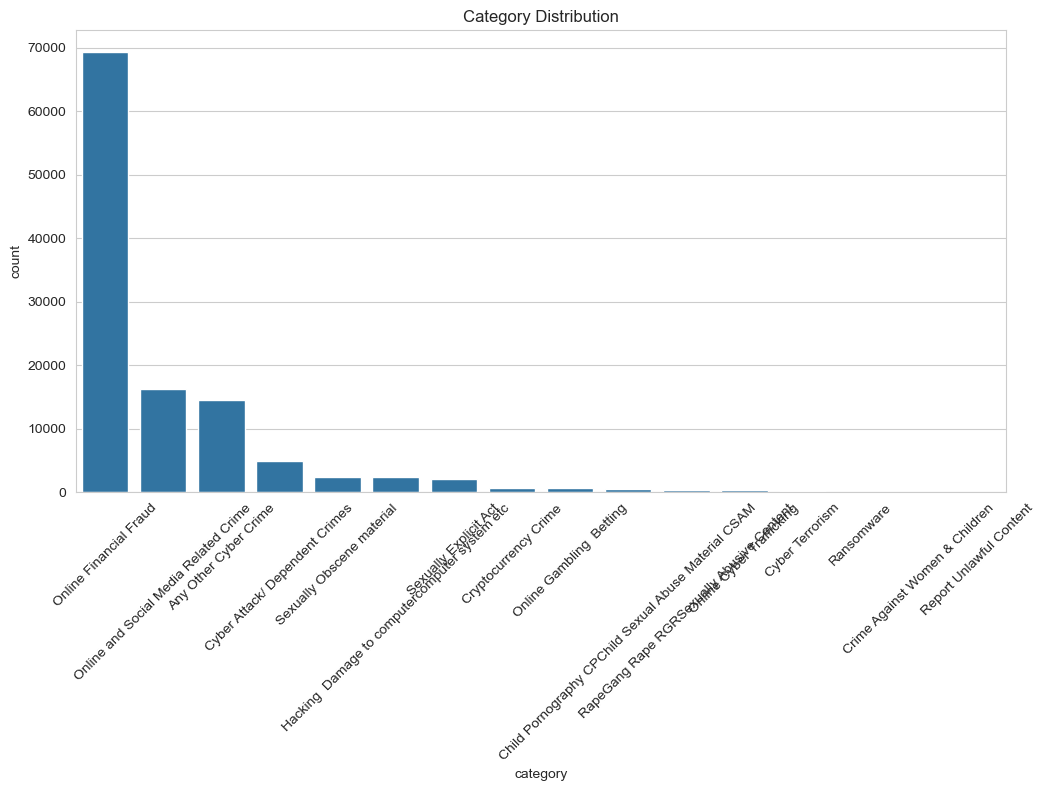

In [129]:
plt.figure(figsize=(12, 6))
sns.countplot(x='category', data=data, order=data['category'].value_counts().index)
plt.title("Category Distribution")
plt.xticks(rotation=45)
plt.show()


In [134]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Ensure necessary resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """Function to clean, tokenize, remove stopwords, lemmatize and normalize text data."""
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Join tokens back to a cleaned text
    cleaned_text = ' '.join(processed_tokens)
    
    return cleaned_text.strip()

# Apply text preprocessing
data['crimeaditionalinfo_cleaned'] = data['crimeaditionalinfo'].apply(preprocess_text)

# Check the result of preprocessing
print(data[['crimeaditionalinfo', 'crimeaditionalinfo_cleaned']].head())


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                  crimeaditionalinfo  \
0  I had continue received random calls and abusi...   
1  The above fraudster is continuously messaging ...   
2  He is acting like a police and demanding for m...   
3  In apna Job I have applied for job interview f...   
4  I received a call from lady stating that she w...   

                          crimeaditionalinfo_cleaned  
0  continue received random call abusive message ...  
1  fraudster continuously messaging asking pay mo...  
2  acting like police demanding money adding sect...  
3  apna job applied job interview telecalling res...  
4  received call lady stating send new phone vivo...  


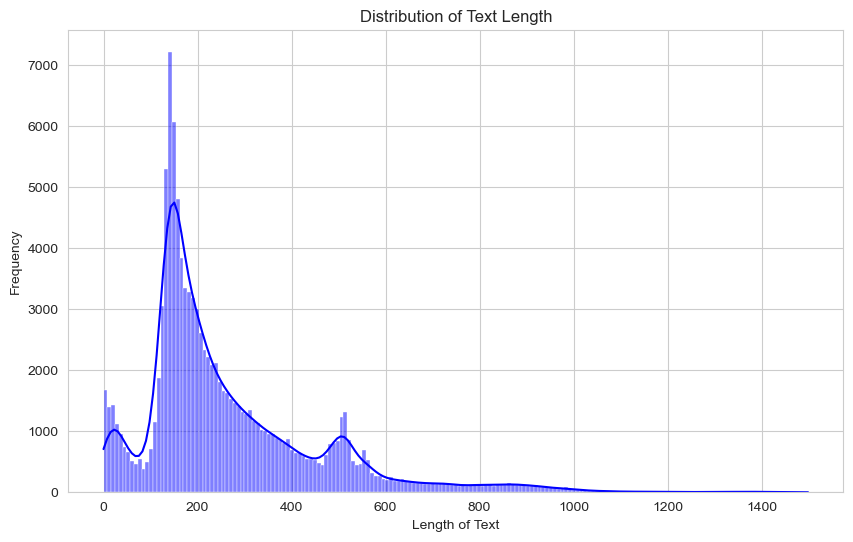

In [136]:
# Plot distribution of text lengths
data['text_length'] = data['crimeaditionalinfo_cleaned'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data['text_length'], kde=True, color='blue')
plt.title('Distribution of Text Length')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.show()


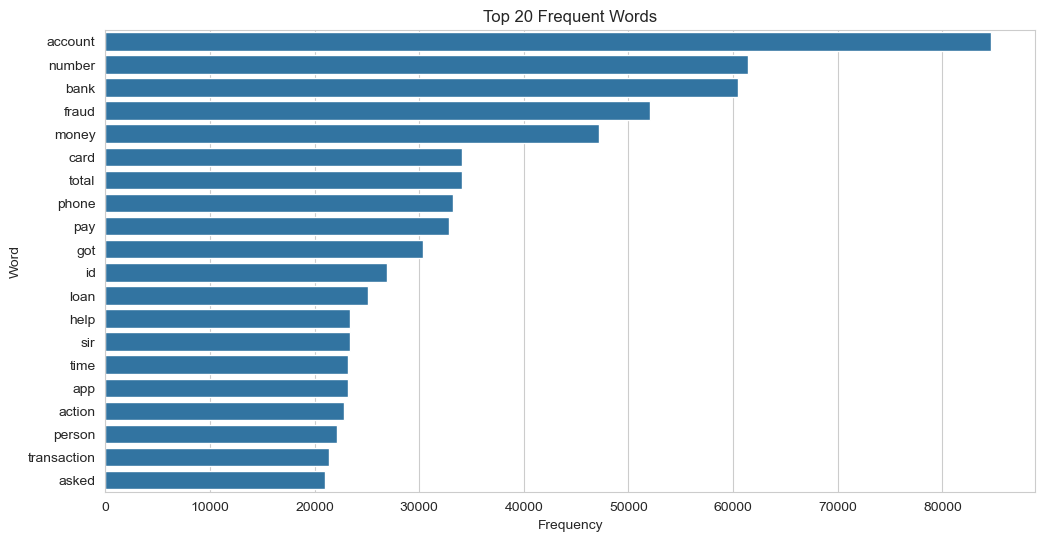

In [138]:
# Display most frequent words
from sklearn.feature_extraction.text import CountVectorizer

# Tokenize text and create frequency distribution
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(data['crimeaditionalinfo_cleaned'])
word_freq = np.asarray(X.sum(axis=0)).flatten()
words = vectorizer.get_feature_names_out()

# Create a dataframe with word frequencies
word_freq_df = pd.DataFrame(list(zip(words, word_freq)), columns=["word", "frequency"])
word_freq_df = word_freq_df.sort_values(by="frequency", ascending=False)

# Plot top 20 frequent words
plt.figure(figsize=(12, 6))
sns.barplot(x="frequency", y="word", data=word_freq_df.head(20))
plt.title("Top 20 Frequent Words")
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()


<class 'pandas.core.frame.DataFrame'>
Index: 113984 entries, 0 to 124914
Data columns (total 5 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   category                    113984 non-null  object
 1   sub_category                113984 non-null  object
 2   crimeaditionalinfo          113984 non-null  object
 3   crimeaditionalinfo_cleaned  113984 non-null  object
 4   text_length                 113984 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 5.2+ MB
None
         text_length
count  113984.000000
mean      266.640379
std       194.163433
min         0.000000
25%       144.000000
50%       202.000000
75%       341.000000
max      1499.000000
Missing Values:
category                      0
sub_category                  0
crimeaditionalinfo            0
crimeaditionalinfo_cleaned    0
text_length                   0
dtype: int64


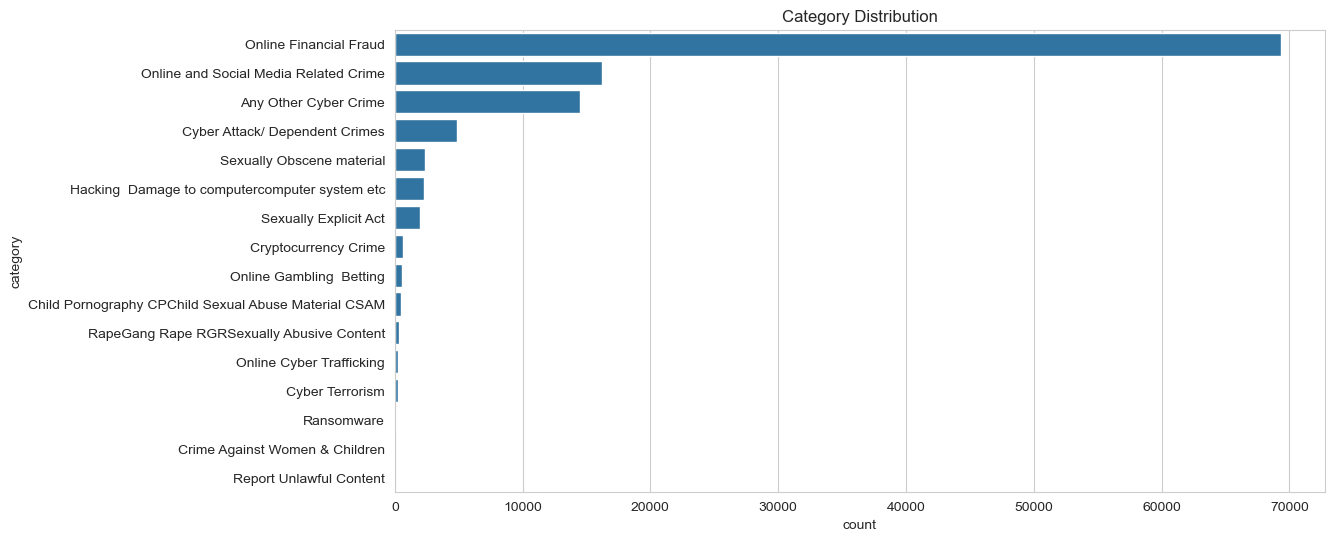

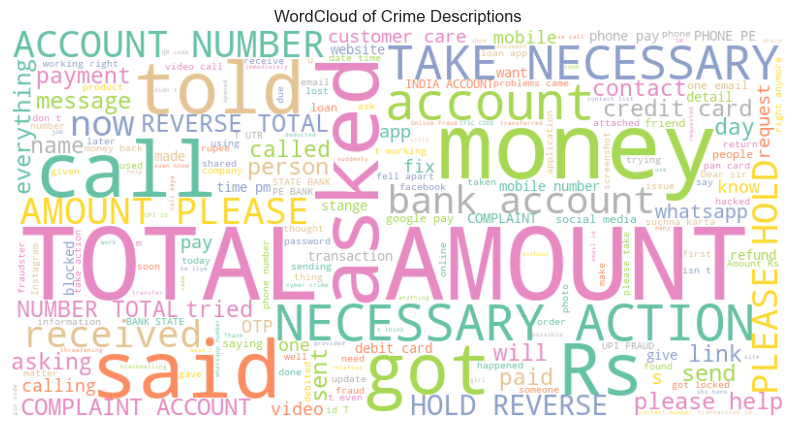

Top 10 Categories:
category
Online Financial Fraud                                  69302
Online and Social Media Related Crime                   16176
Any Other Cyber Crime                                   14455
Cyber Attack/ Dependent Crimes                           4869
Sexually Obscene material                                2364
Hacking  Damage to computercomputer system etc           2299
Sexually Explicit Act                                    1977
Cryptocurrency Crime                                      631
Online Gambling  Betting                                  578
Child Pornography CPChild Sexual Abuse Material CSAM      471
Name: count, dtype: int64
Top Sub-Categories by Category:
category                                              sub_category                                                        
Any Other Cyber Crime                                 Other                                                                   14455
Child Pornography CPChild Sexual Abuse 

In [140]:
# Cell 3: Exploratory Data Analysis (EDA)

# Display basic information about the dataset
print(data.info())
print(data.describe())

# Check for missing values
missing_values = data.isnull().sum()
print(f"Missing Values:\n{missing_values}")

# Visualize category distribution
plt.figure(figsize=(12, 6))
sns.countplot(y='category', data=data, order=data['category'].value_counts().index)
plt.title("Category Distribution")
plt.show()

# Generate a WordCloud for the text data
text = " ".join(data['crimeaditionalinfo'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Set2').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Crime Descriptions")
plt.show()

# Display top 10 categories and their sub-categories
top_categories = data['category'].value_counts().head(10)
print("Top 10 Categories:")
print(top_categories)

print("Top Sub-Categories by Category:")
print(data.groupby('category')['sub_category'].value_counts().head(10))


In [142]:
# Check class distribution
print("Class distribution in y_train:")
print(y_train.value_counts())


Class distribution in y_train:
category_encoded
8     61005
10    13024
0     11728
4      3861
12     3010
15     1998
6      1854
14     1649
3       520
9       475
1       400
7       188
5       160
11       57
2         3
Name: count, dtype: int64


In [145]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 2))  # For bigrams
X = vectorizer.fit_transform(data['crimeaditionalinfo_cleaned'])


In [147]:
text = re.sub(r'http\S+', 'URL', text)  # Replace URLs with 'URL'
text = re.sub(r'\S+@\S+', 'EMAIL', text)  # Replace emails with 'EMAIL'


In [197]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Ensure train-test split is done
# from sklearn.model_selection import train_test_split
# train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Combine train and test data categories for LabelEncoder
all_categories = pd.concat([train_data['category'], test_data['category']], axis=0)
label_encoder_category = LabelEncoder()
label_encoder_category.fit(all_categories)

# Transform 'category' with unseen label handling
train_data['category_encoded'] = label_encoder_category.transform(train_data['category'])
test_data['category_encoded'] = test_data['category'].apply(
    lambda x: label_encoder_category.transform([x])[0] if x in label_encoder_category.classes_ else -1
)

# Handle unseen labels in the test set
unseen_labels = test_data[test_data['category_encoded'] == -1]
if not unseen_labels.empty:
    print(f"Unseen labels in 'category' column:\n{unseen_labels['category'].unique()}")
    print("Assigning default label to unseen labels.")
    test_data['category_encoded'] = test_data['category_encoded'].replace(-1, len(label_encoder_category.classes_))

# Repeat for 'sub_category'
all_sub_categories = pd.concat([train_data['sub_category'], test_data['sub_category']], axis=0)
label_encoder_sub_category = LabelEncoder()
label_encoder_sub_category.fit(all_sub_categories)

train_data['sub_category_encoded'] = label_encoder_sub_category.transform(train_data['sub_category'])
test_data['sub_category_encoded'] = test_data['sub_category'].apply(
    lambda x: label_encoder_sub_category.transform([x])[0] if x in label_encoder_sub_category.classes_ else -1
)

unseen_sub_labels = test_data[test_data['sub_category_encoded'] == -1]
if not unseen_sub_labels.empty:
    print(f"Unseen labels in 'sub_category' column:\n{unseen_sub_labels['sub_category'].unique()}")
    print("Assigning default label to unseen sub-category labels.")
    test_data['sub_category_encoded'] = test_data['sub_category_encoded'].replace(-1, len(label_encoder_sub_category.classes_))

# Vectorize text using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(train_data['crimeaditionalinfo_cleaned'])
X_test_tfidf = tfidf.transform(test_data['crimeaditionalinfo_cleaned'])

# Combine text and categorical features
X_train = np.hstack((X_train_tfidf.toarray(), train_data[['category_encoded', 'sub_category_encoded']].values))
X_test = np.hstack((X_test_tfidf.toarray(), test_data[['category_encoded', 'sub_category_encoded']].values))

# Labels for classification
y_train = train_data['category_encoded']
y_test = test_data['category_encoded']

print("Data preprocessing completed successfully!")


Data preprocessing completed successfully!


In [199]:
print(X_train.shape)  # Should match (number_of_samples, total_features)
print(X_test.shape)


(91187, 5002)
(22797, 5002)


In [201]:
# Cell 7: Feature Scaling without SMOTE

from sklearn.preprocessing import StandardScaler

# First, scale the features only for models that require scaling
scaler = StandardScaler()

# Logistic Regression and Random Forest will use scaled data
X_train_scaled = scaler.fit_transform(X_train)  # Scale the training features
X_test_scaled = scaler.transform(X_test)        # Scale the testing features

# For Naive Bayes, do not scale the data, use raw TF-IDF features
X_train_raw = X_train_tfidf.toarray()
X_test_raw = X_test_tfidf.toarray()

# Check the distribution of classes before applying any resampling
print("Class distribution in y_train before resampling:")
print(y_train.value_counts())


Class distribution in y_train before resampling:
category_encoded
8     55396
10    12957
0     11560
4      3902
15     1892
6      1842
14     1582
3       521
9       456
1       386
12      273
7       193
5       166
11       57
2         3
13        1
Name: count, dtype: int64


In [203]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize and train the model
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_log_reg = log_reg_model.predict(X_test_scaled)

# Evaluate the model
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("Classification Report:\n", classification_report(y_test, y_pred_log_reg))


Logistic Regression Accuracy: 0.9173575470456639
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      2895
           1       0.55      0.49      0.52        85
           2       0.00      0.00      0.00         1
           3       0.70      0.68      0.69       110
           4       1.00      1.00      1.00       967
           5       0.09      0.06      0.07        47
           6       0.45      0.49      0.47       457
           7       0.01      0.02      0.02        51
           8       0.97      0.96      0.96     13906
           9       0.13      0.16      0.15       122
          10       0.95      0.92      0.93      3219
          11       0.75      0.35      0.48        17
          12       0.10      0.13      0.11        53
          14       0.37      0.42      0.39       395
          15       0.51      0.57      0.54       472

    accuracy                           0.92     22797
   macr

C:\Users\harsh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\harsh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\harsh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [205]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the model
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.9584594464183884
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2895
           1       0.90      0.52      0.66        85
           2       0.00      0.00      0.00         1
           3       1.00      0.85      0.92       110
           4       1.00      1.00      1.00       967
           5       0.60      0.06      0.12        47
           6       0.97      0.55      0.70       457
           7       1.00      0.10      0.18        51
           8       0.96      1.00      0.98     13906
           9       1.00      0.09      0.17       122
          10       0.94      0.96      0.95      3219
          11       1.00      0.06      0.11        17
          12       1.00      0.13      0.23        53
          14       0.90      0.56      0.69       395
          15       0.89      0.78      0.83       472

    accuracy                           0.96     22797
   macro avg 

C:\Users\harsh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\harsh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\harsh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [207]:
from sklearn.naive_bayes import MultinomialNB

# Initialize and train the model
nb_model = MultinomialNB()
nb_model.fit(X_train_raw, y_train)

# Make predictions
y_pred_nb = nb_model.predict(X_test_raw)

# Evaluate the model
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.717594420318463
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.28      0.32      2895
           1       0.75      0.14      0.24        85
           2       0.00      0.00      0.00         1
           3       0.79      0.14      0.23       110
           4       1.00      1.00      1.00       967
           5       0.00      0.00      0.00        47
           6       0.31      0.16      0.21       457
           7       0.00      0.00      0.00        51
           8       0.82      0.89      0.85     13906
           9       0.00      0.00      0.00       122
          10       0.49      0.66      0.57      3219
          11       0.00      0.00      0.00        17
          12       0.00      0.00      0.00        53
          14       0.00      0.00      0.00       395
          15       0.71      0.01      0.02       472

    accuracy                           0.72     22797
   macro avg    

C:\Users\harsh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\harsh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\harsh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [209]:
### PCA and reduced grid search parameters
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Reduce dimensions with PCA
pca = PCA(n_components=100)
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

# Define a smaller parameter grid for GridSearchCV
param_grid = {
    'C': [1],  # Test one value for C to reduce the number of fits
    'solver': ['liblinear']  # Test one solver for simplicity
}

# Initialize and tune the model
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train_scaled_pca, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Evaluate with best model
y_pred_grid = grid_search.best_estimator_.predict(X_test_scaled_pca)
print("Accuracy after Grid Search:", accuracy_score(y_test, y_pred_grid))


C:\Users\harsh\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best parameters: {'C': 1, 'solver': 'liblinear'}
Best score: 0.7383179507426175
Accuracy after Grid Search: 0.7371145326139404


In [213]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


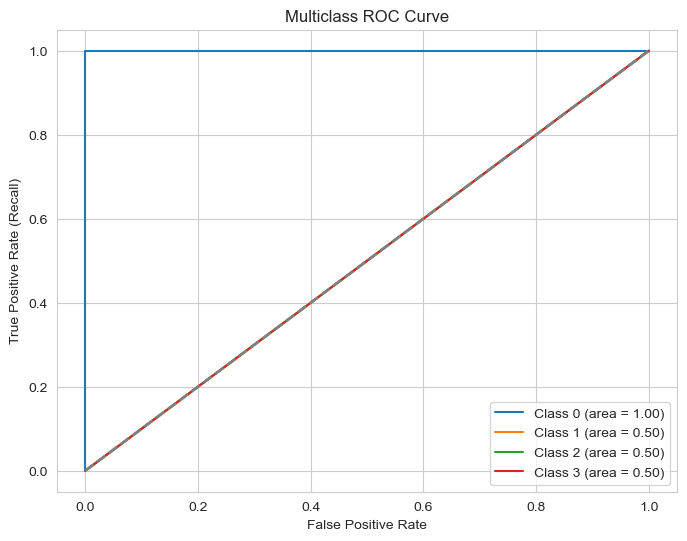

In [215]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the true labels for multiclass ROC (convert to one-hot encoding)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Change based on your number of classes
n_classes = y_test_bin.shape[1]

# Get the predicted probabilities for each class
y_pred_prob = model.predict_proba(X_test)

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()


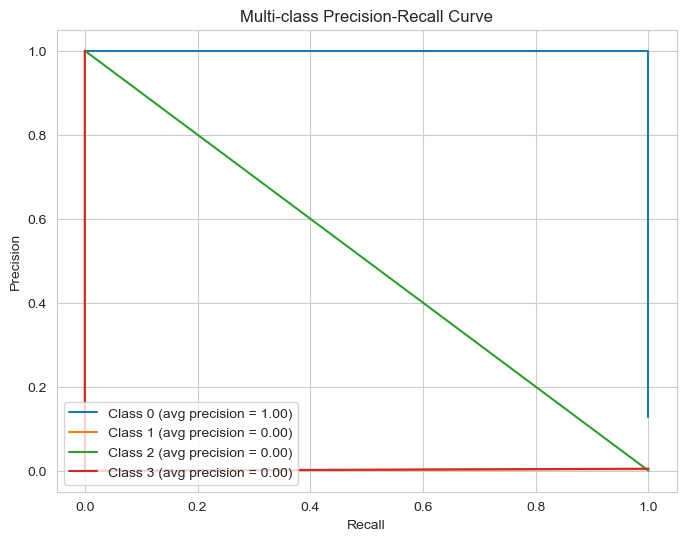

In [217]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Binarize the true labels for multiclass (convert to one-hot encoding)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Adjust this based on your class labels
n_classes = y_test_bin.shape[1]

# Get the predicted probabilities for each class
y_pred_prob = model.predict_proba(X_test)

# Plot Precision-Recall for each class
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label='Class {0} (avg precision = {1:0.2f})'.format(i, avg_precision))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-class Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


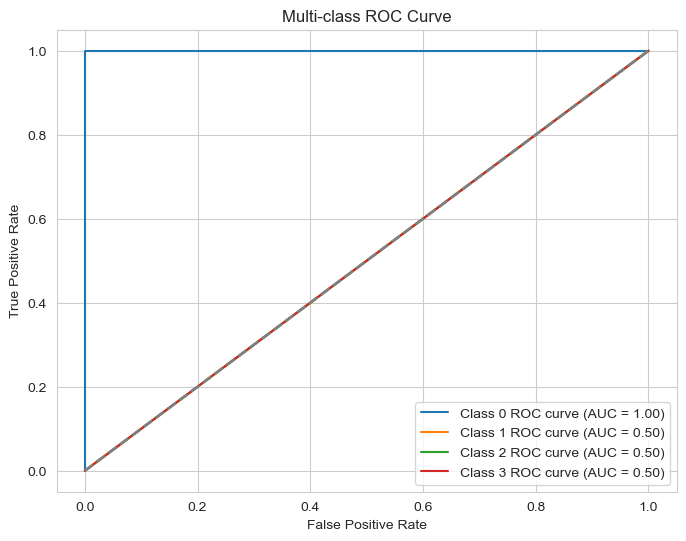

In [219]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Binarize the true labels for multiclass (convert to one-hot encoding)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Adjust this based on your class labels
n_classes = y_test_bin.shape[1]

# Get the predicted probabilities for each class
y_pred_prob = model.predict_proba(X_test)

# Plot ROC for each class
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Class {0} ROC curve (AUC = {1:0.2f})'.format(i, roc_auc))

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()


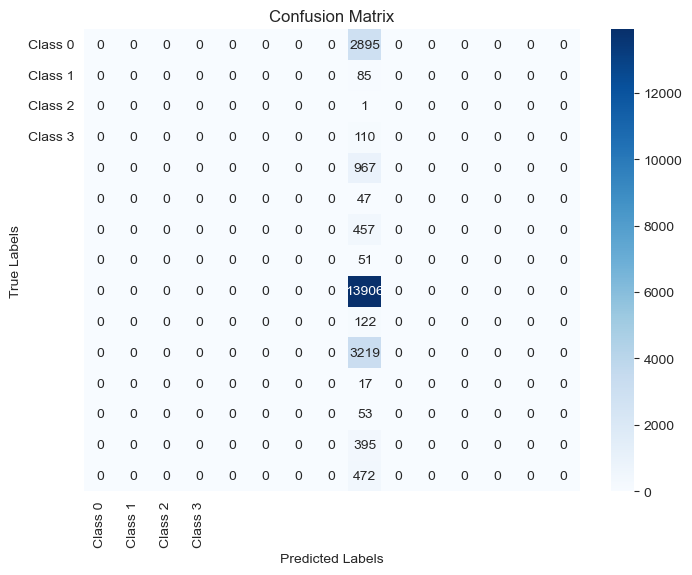

In [221]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions
y_pred = model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [223]:
import joblib

# Save the Random Forest model
joblib.dump(rf_model, 'random_forest_model.pkl')


['random_forest_model.pkl']

In [225]:
# Load the Random Forest model
rf_model_loaded = joblib.load('random_forest_model.pkl')

# Make predictions using the loaded model
y_pred_loaded = rf_model_loaded.predict(X_test_scaled)

# Evaluate the model
print("Loaded Random Forest Accuracy:", accuracy_score(y_test, y_pred_loaded))
print("Loaded Classification Report:\n", classification_report(y_test, y_pred_loaded))


Loaded Random Forest Accuracy: 0.9584594464183884
Loaded Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2895
           1       0.90      0.52      0.66        85
           2       0.00      0.00      0.00         1
           3       1.00      0.85      0.92       110
           4       1.00      1.00      1.00       967
           5       0.60      0.06      0.12        47
           6       0.97      0.55      0.70       457
           7       1.00      0.10      0.18        51
           8       0.96      1.00      0.98     13906
           9       1.00      0.09      0.17       122
          10       0.94      0.96      0.95      3219
          11       1.00      0.06      0.11        17
          12       1.00      0.13      0.23        53
          14       0.90      0.56      0.69       395
          15       0.89      0.78      0.83       472

    accuracy                           0.96     22797

C:\Users\harsh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\harsh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\harsh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [237]:
# Preprocess and predict on new input data

def test_input(model, tfidf_vectorizer, label_encoder, category_encoder, sub_category_encoder, text_input, sub_category_input):
    """
    Function to preprocess input and predict its category using the trained model.
    
    Args:
    - model: Trained classification model.
    - tfidf_vectorizer: Fitted TF-IDF vectorizer.
    - label_encoder: Encoder for the labels.
    - category_encoder: Encoder for category features.
    - sub_category_encoder: Encoder for sub-category features.
    - text_input: Raw text input (crimeaditionalinfo).
    - sub_category_input: Sub-category input for the text.
    
    Returns:
    - Predicted category label.
    """
    try:
        # Preprocess the input text
        text_cleaned = preprocess_text(text_input)
        
        # Transform text input with TF-IDF vectorizer
        text_tfidf = tfidf_vectorizer.transform([text_cleaned]).toarray()
        
        # Encode sub-category
        sub_category_encoded = sub_category_encoder.transform([sub_category_input]).reshape(-1, 1)
        
        # Combine features
        features = np.hstack((text_tfidf, sub_category_encoded))
        
        # Predict the category
        prediction = model.predict(features)
        
        # Decode the prediction
        predicted_label = label_encoder.inverse_transform(prediction)
        
        return f"Predicted Category: {predicted_label[0]}"
    
    except Exception as e:
        return f"Error during prediction: {e}"

# Example Input
input_text = "The victim reported unauthorized transactions from their bank account."
input_sub_category = "Financial Fraud"

# Ensure encoders and trained models are loaded
print(test_input(log_reg_model, tfidf, label_encoder, label_encoder, label_encoder, input_text, input_sub_category))


Error during prediction: y contains previously unseen labels: 'Financial Fraud'
